In [1]:

import torch.nn as nn    
    
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms
import os
from torch.optim import Adam
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Define the CNN backbone (shared for both inputs)
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )

        # Fully connected layer for similarity
        self.fc = nn.Sequential(
            nn.Linear(64, 256), 
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1), 
            nn.Sigmoid()  # Binary classification: Similar (1) or Not Similar (0)
        )

    def forward_one(self, x):
        # Forward pass for one input
        x = self.backbone(x)
        x = x.view(x.size()[0], -1)  # Flatten
        return x

    def forward(self, input1, input2):
        # Forward pass for both inputs
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        
        #print('out1',output1.size())
        
        # Compute the distance between the two embeddings.
        euclidean_distance = torch.abs(output1 - output2)
        #print('euc',euclidean_distance.size())
        # Similarity prediction
        similarity = self.fc(euclidean_distance)
        return similarity

    def get_embedding(self, x):
        # Method to get the embedding of a single image
        return self.forward_one(x)
    
class CellTrackingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Load all TXT files in root_dir into a list of dataframes
        all_dfs = []
        for folder in os.listdir(root_dir):
            # Check if the folder's name ends with '_GT'
            if folder.endswith("_GT"):
                file_path = os.path.join(root_dir, folder, 'pos_GT.txt')
                # Check if 'pos_GT.txt' actually exists in the folder
                if os.path.exists(file_path):
                    #print('file', file_path)
                    run = int(folder.split('_')[0])  # extract run number from folder name
                    #print('run', run)
                    df = pd.read_csv(file_path, delimiter='\t', skiprows=1, 
                                     names=['x', 'y', 'r', 'id', 'split_id', 's_prob', 't'])
                    df['run'] = run  # Add a run column
                    all_dfs.append(df)

        self.data = pd.concat(all_dfs, ignore_index=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # TODO: Implement logic to decide positive or negative pair
        # For example, 50% of the time it returns positive pairs, and 50% negative pairs
        positive_sample = np.random.choice([True, False])

        if positive_sample:
            # Load two consecutive frames of the same cell
            #print("IDX:", idx, "DATA LENGTH:", len(self.data), self.data.iloc[idx])
            frame_t, frame_t_plus_1 = self._load_consecutive_frames(self.data.iloc[idx])
            label = torch.tensor([1.0])
        else:
            # Load frames of two different cells (from consecutive frames)
            #print("IDX:", idx, "DATA LENGTH:", len(self.data), self.data.iloc[idx])
            frame_t, frame_t_plus_1 = self._load_different_cells_frames(self.data.iloc[idx])
            label = torch.tensor([0.0])

        return (frame_t, frame_t_plus_1), label

    def _load_consecutive_frames(self, row):
        # Find the next frame's cell that has either the same 'id' 
        # or has 'split_id' matching the current 'id'
        same_cell_or_daughter = self.data[(self.data['t'] == row['t'] + 1) & 
                                          (self.data['run'] == row['run']) & 
                                          ((self.data['id'] == row['id']) | 
                                           (self.data['split_id'] == row['id']))]

        if not same_cell_or_daughter.empty:
            next_frame_same_cell = same_cell_or_daughter.iloc[0]
            frame_t_plus_1 = self._load_frame(next_frame_same_cell)
        else:
            # Handle the scenario when no such cell exists in the next frame
            frame_t_plus_1 = torch.zeros_like(self._load_frame(row))  # Placeholder, modify as needed

        frame_t = self._load_frame(row)

        return frame_t, frame_t_plus_1

    def _load_different_cells_frames(self, row):
        # Find another cell from the next frame but within the same run 
        # and is not a daughter cell (i.e., its 'split_id' doesn't match the current cell's 'id')
        next_frame_data = self.data[(self.data['t'] == row['t'] + 1) & 
                                    (self.data['run'] == row['run']) & 
                                    (self.data['split_id'] != row['id'])]

        # Ensure that you're getting a different cell, but from the same run
        different_cell = next_frame_data[next_frame_data['id'] != row['id']]

        if not different_cell.empty:
            different_cell_row = different_cell.iloc[0]
            frame_t_plus_1 = self._load_frame(different_cell_row)
        else:
            # Handle the scenario when no different cell exists in t+1 frame
            frame_t_plus_1 = torch.zeros_like(self._load_frame(row))  # Placeholder, modify as needed

        frame_t = self._load_frame(row)

        return frame_t, frame_t_plus_1
    def _load_frame(self, row):
        # Extract position and run from the row
        pos_x, pos_y, run, t = row['x'], row['y'], row['run'], row['t']
        window=20
        # Using the fingerprint_cnn function to get the tensor
        im_tens = fingerprint_cnn(pos_x, pos_y, window, t, run)
        return im_tens
    
def fingerprint_cnn(pos_x,pos_y,window,t,run,void_node=False,a_x=113.89266922,b_x=19.51478307,a_y=-114.14194117,b_y=131.3404747):
    
    if void_node:
        pos_x = 0.74
        pos_y = 0.8
        x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)
        
        path='/home/mo/Desktop/IWR/TimeGraph2.0/void.png'
        
        im = Image.open(path).convert('L')
        shape = np.asarray(im).shape
        
        im_crop = im.crop((x_l, y_l, x_r, y_u))

        if t==9 and run==95:
            im_crop.show()


        im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
        
        imarray = np.asarray(im_crop)
        

        im_tens=torch.zeros(3, 20,20)


        convert_tensor = transforms.ToTensor()
        im_tens[1]=convert_tensor(imarray)
        im_tens[0]=convert_tensor(imarray)
        im_tens[2]=convert_tensor(imarray)
        
    
    else:
        
        x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)


        pathm1='/home/mo/Desktop/IWR/TimeGraph2.0/dot_folder/'+str(int(run))+'/'+str(int(t-1))+'.png'
        path='/home/mo/Desktop/IWR/TimeGraph2.0/dot_folder/'+str(int(run))+'/'+str(int(t))+'.png'
        pathp1='/home/mo/Desktop/IWR/TimeGraph2.0/dot_folder/'+str(int(run))+'/'+str(int(t+1))+'.png'


        im = Image.open(path).convert('L')
        shape = np.asarray(im).shape
        try:
            im_m = Image.open(pathm1).convert('L')
        except:
            pix=255*np.ones(shape)
            im_m = Image.fromarray(pix).convert('L')
        try:
            im_p = Image.open(pathp1).convert('L')
        except:
            pix=255*np.ones(shape)
            im_p = Image.fromarray(pix).convert('L')





        im_crop = im.crop((x_l, y_l, x_r, y_u))
        im_m_crop = im_m.crop((x_l, y_l, x_r, y_u))
        im_p_crop = im_p.crop((x_l, y_l, x_r, y_u))






        #if t==9 and run==95:
        #    im_crop.show()


        im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
        im_m_crop = im_m_crop.resize((20,20),Image.ANTIALIAS)
        im_p_crop = im_p_crop.resize((20,20),Image.ANTIALIAS)

        imarray = np.asarray(im_crop)
        #print('shape',imarray.shape)
        im_m_array = np.asarray(im_m_crop)
        im_p_array = np.asarray(im_p_crop)


        im_tens=torch.zeros(3, 20,20)


        convert_tensor = transforms.ToTensor()
        im_tens[1]=convert_tensor(imarray)
        im_tens[0]=convert_tensor(im_m_array)
        im_tens[2]=convert_tensor(im_p_array)

    return im_tens

def calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window):
    pix_x0=int(fit_func(pos_x,a_x,b_x))
    
    pix_y0=int(fit_func(pos_y,a_y,b_y))
    #print(pix_x0,pix_y0,int(pix_x0-window))
    return int(pix_x0-window),int(pix_x0+window),int(pix_y0-window),int(pix_y0+window)


def imshow(img1, img2, label):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Assuming images are normalized pytorch tensors, convert them to numpy and de-normalize if necessary
    ax1.imshow(img1.numpy().transpose(1, 2, 0))
    ax2.imshow(img2.numpy().transpose(1, 2, 0))
    
    # Display the label
    fig.suptitle(f"Label: {label.item()}")
    plt.show()
    

def fit_func(x,a,b):
    return a*x+b


def extract_embeddings_subset(dataloader, model):
    model.eval()
    
    embeddings = np.zeros((20, 64))
    labels = np.zeros(20)
    k = 0
    positive_count, negative_count = 0, 0

    with torch.no_grad():
        for (input1, input2), batch_targets in dataloader:
            for idx, label in enumerate(batch_targets):  # Iterate through each label in the batch
                if label.item() == 1.0 and positive_count < 5:
                    embeddings[k] = model.get_embedding(input1[idx].unsqueeze(0)).data.cpu().numpy()
                    embeddings[k+1] = model.get_embedding(input2[idx].unsqueeze(0)).data.cpu().numpy()
                    labels[k] = 1.0
                    labels[k+1] = 1.0
                    k += 2
                    positive_count += 1

                elif label.item() == 0.0 and negative_count < 5:
                    embeddings[k] = model.get_embedding(input1[idx].unsqueeze(0)).data.cpu().numpy()
                    embeddings[k+1] = model.get_embedding(input2[idx].unsqueeze(0)).data.cpu().numpy()
                    labels[k] = 0.0
                    labels[k+1] = 0.0
                    k += 2
                    negative_count += 1

                if positive_count >= 5 and negative_count >= 5:
                    break

    return embeddings, labels

def plot_embeddings(embeddings, labels, title=''):
    plt.figure(figsize=(10, 10))
    colors = ['blue' if label == 1.0 else 'red' for label in labels]
    
    for i in range(0, len(labels), 2):  # We are skipping every second one because we know they come in pairs
        plt.plot(embeddings[i:i+2, 0], embeddings[i:i+2, 1], '-o', c=colors[i], mfc='white') # Line between pair
        
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=colors, s=60, edgecolors='w')
    plt.title(title)
    plt.show()

def visualize_tsne_pca(dataloader, model):
    embeddings, labels = extract_embeddings_subset(dataloader, model)
    embeddings_tsne = TSNE(n_components=2, perplexity=5).fit_transform(embeddings)  # Adjusted perplexity here
    embeddings_pca = PCA(n_components=2).fit_transform(embeddings)
    plot_embeddings(embeddings_tsne, labels, title="t-SNE visualization of embeddings")
    plot_embeddings(embeddings_pca, labels, title="PCA visualization of embeddings")


    
# Usage:
#data = ... # Load your ground truth data here, for instance as a Pandas DataFrame
root_dir = '/home/mo/Desktop/IWR/TimeGraph2.0/dot_folder/'
#import os

#for folder in os.listdir(root_dir):
#    print(folder, os.listdir(os.path.join(root_dir, folder)))

dataset = CellTrackingDataset( root_dir)

#print(stop)

In [3]:
model = SiameseNetwork()
optimizer = Adam(model.parameters(), lr=0.001)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for (input1, input2), labels in dataloader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input1, input2).squeeze()
        
        # Convert the continuous valued outputs to binary predictions
        predicted_labels = (outputs > 0.5).float()
        correct_predictions += (predicted_labels == labels.squeeze()).float().sum().item()
        total_samples += labels.size(0)
        
        # Compute loss
        loss = F.binary_cross_entropy(outputs, labels.squeeze())
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    epoch_accuracy = 100 * correct_predictions / total_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}, Accuracy: {epoch_accuracy:.2f}%")


/tmp/ipykernel_491785/687586462.py:211: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
/tmp/ipykernel_491785/687586462.py:212: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_m_crop = im_m_crop.resize((20,20),Image.ANTIALIAS)
/tmp/ipykernel_491785/687586462.py:213: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_p_crop = im_p_crop.resize((20,20),Image.ANTIALIAS)
/home/mo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data o

Epoch 1/2, Loss: 0.5626773824266736, Accuracy: 69.09%
Epoch 2/2, Loss: 0.4455825378262233, Accuracy: 79.32%


/tmp/ipykernel_491785/1827530807.py:211: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
/tmp/ipykernel_491785/1827530807.py:212: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_m_crop = im_m_crop.resize((20,20),Image.ANTIALIAS)
/tmp/ipykernel_491785/1827530807.py:213: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_p_crop = im_p_crop.resize((20,20),Image.ANTIALIAS)


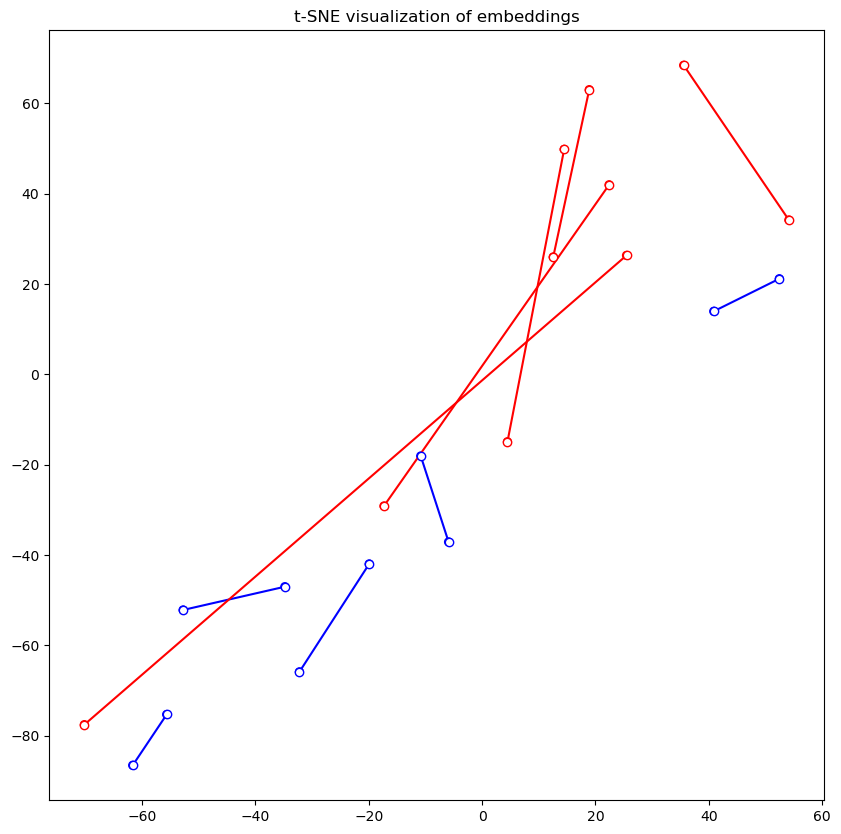

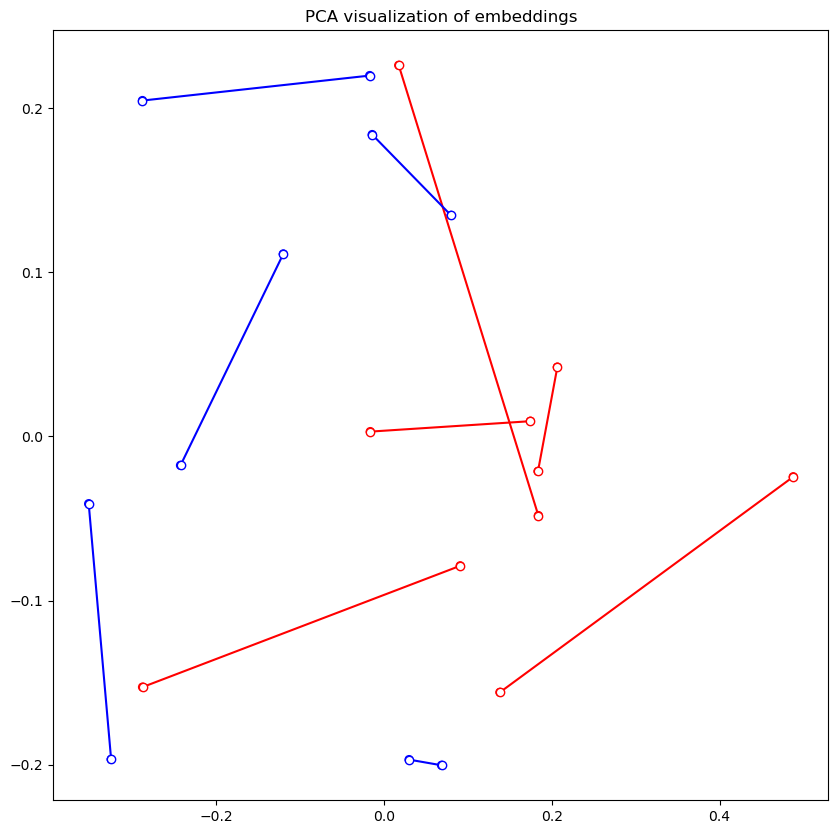

In [6]:
visualize_tsne_pca(dataloader, model)